In [19]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
from time import sleep
from IPython.display import clear_output
%matplotlib inline
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import pandas as pd

In [21]:
class MyEnv(gym.Env):
    def __init__(self, n=8):
        assert n % 4 == 0, "n must be a multiple of 4 for symmetry"
        self.n = n
        self.angles = np.linspace(0, 2*np.pi, n, endpoint=False)  # Equally spaced angles
        self.action_vectors = np.column_stack((np.cos(self.angles), np.sin(self.angles)))
        self.r_outer = 1.2
        self.action_space = spaces.Discrete(n)
        self.observation_space = spaces.Box(low=np.array([-2.0, -2.0]), high=np.array([2.0, 2.0]))
        self.state = np.array([0.0, 0.0])
        self.step_size = 0.15
        self.env_shape = "SQUARE"
        self.trajectory = [self.state.copy()]

    def reset(self, init=False, point=np.array([0,0])):
        if not init:
            self.state = np.random.rand(2) * 4 - 2  # Anywhere in [-2,2]
        else:
            self.state = point
        self.trajectory = [self.state.copy()]
        return self.state

    def step(self, action):
        x, y = self.state
        delta_action = self.action_vectors[action] * self.step_size
        x_new = x + delta_action[0]
        y_new = y + delta_action[1]
        
        # Reflect at boundaries
        if x_new < -2:
            x_new = -4 - x_new  # Reflect from -2 boundary
        elif x_new > 2:
            x_new = 4 - x_new  # Reflect from 2 boundary
        
        if y_new < -2:
            y_new = -4 - y_new  # Reflect from -2 boundary
        elif y_new > 2:
            y_new = 4 - y_new  # Reflect from 2 boundary
        
        self.state = np.array([x_new, y_new])
        reward = 0
        done = False
        
        if np.sqrt(self.state[0]**2 + self.state[1]**2) <= self.r_outer**2:
            reward += 1.0
        elif -2.0 < x_new < 2.0 and -2.0 < y_new < 2.0:
            reward -= 1.0
        else:
            reward -= 2.0
        
        self.trajectory.append(self.state.copy())
        return self.state, reward, done, {}

    def render(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        x_coords = [point[0] for point in self.trajectory]
        y_coords = [point[1] for point in self.trajectory]
        
        square_2 = patches.Rectangle((-2, -2), 4, 4, linewidth=1, edgecolor='k', linestyle='--', facecolor='gray', alpha=0.7)
        ax.add_patch(square_2)
        outer_circle = patches.Circle((0, 0), self.r_outer, linewidth=1, edgecolor='k',
                                  facecolor='gold', alpha=0.6, label='Reward Region')
        # inner_circle = patches.Circle((0, 0), self.r_inner, linewidth=3, edgecolor='k',facecolor='gray', alpha=0.7)

        ax.add_patch(outer_circle)
        # ax.add_patch(inner_circle)

        # Masking inner circle out by drawing it in background color (optional)
        # ax.add_patch(patches.Circle((0, 0), self.r_inner, facecolor='gray', edgecolor='gray'))
        
        ax.plot(x_coords, y_coords, label='Trajectory')
        ax.scatter(x_coords[-1], y_coords[-1], color='red', label='Agent')
        ax.scatter(x_coords[0], y_coords[0], color='black', label='Initial Point')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_title("Environment")
        ax.set_xlabel("X axis")
        ax.set_ylabel("Y axis")
        ax.legend()

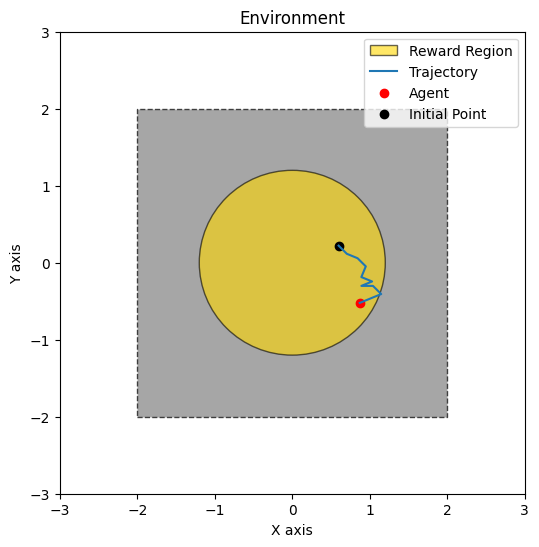

Reward :  10.0


In [39]:
env = MyEnv(n=16)
state = env.reset()
total_reward = 0
for i in range(10):
    action = env.action_space.sample()  # Random direction
    state, reward, done, _ = env.step(action)
    total_reward += reward
env.render()
plt.show()
print("Reward : ", total_reward)

In [11]:
class Shared_model(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(Shared_model, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.action_dim = action_dim
        self.actor = nn.Linear(hidden_size, action_dim)  # Mean of the action distribution
        self.value = nn.Linear(hidden_size, 1)  # Output a single value representing state value
        self.beta_sigmoid = 10
        self.init_weights()
        
    def init_weights(self):
        # Xavier Initialization for fc1 and fc2
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.actor.weight)
        nn.init.xavier_uniform_(self.value.weight)

        # Set biases for positive value output
        nn.init.constant_(self.fc1.bias, 0.1)
        nn.init.constant_(self.fc2.bias, 0.1)
        nn.init.constant_(self.actor.bias, 0.0)  
        nn.init.constant_(self.value.bias, 1.0)
    
    def forward(self, state, threshold=0):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        val = self.value(x)
        action_d1 = self.actor(torch.relu(self.fc3(x)))
        action_d2 = torch.rand(self.action_dim)
        sigmoid_ = 1 / (1 + torch.exp(-self.beta_sigmoid * (val - threshold)))
        action = F.softmax((1-sigmoid_) * action_d1 + sigmoid_ * action_d2, dim=-1)
        return action, val

In [34]:
def actor_critic_bg(model_shared, episodes, max_steps=100, gamma=0.99, lr_shared=1e-5, n=8):
    optimizer_shared = optim.Adam(model_shared.parameters(), lr=lr_shared)
    stats = {'Total Loss': [], 'Returns': [], 'a_loss':[], 'c_loss':[]}
    env = MyEnv(n)
    for episode in range(1, episodes + 1):
        state = env.reset()
        ep_return = 0
        done = False
        step_count = 0
        # if episode<1000:
        #     threshold = -5
        # elif episode>=1000 and episode<2000:
        #     threshold = -1
        # elif episode>=2000:
        #     threshold = 0
        threshold = 0
        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state)
            action_probs, val = model_shared(state_tensor, threshold)
            action_prob, action = torch.max(action_probs, dim=0)       
            next_state, reward, done, _ = env.step(action)
            next_value = model_shared(torch.FloatTensor(state), threshold)[1]
            td_target = reward + gamma * next_value * (1 - done)
            advantage = td_target - val
            critic_loss = F.mse_loss(val, td_target.detach())
            log_prob = torch.log(action_prob)
            actor_loss = -log_prob * advantage.detach()
            total_loss = actor_loss + critic_loss
            optimizer_shared.zero_grad()
            total_loss.backward()
            optimizer_shared.step()
            state = next_state
            ep_return += reward
            step_count += 1
        if episode%100==0:
            fig, axs = plt.subplots(1, 2, figsize=(8,4))
            # First plot: Value Function
            x = np.arange(-2, 2.01, 0.01)
            y = np.arange(2, -2.01, -0.01)
            xx, yy = np.meshgrid(x, y)
            grid_points = np.column_stack([xx.ravel(), yy.ravel()])
            y_pred = np.squeeze(model_shared(torch.FloatTensor(grid_points))[1].detach().numpy()).reshape(401, 401)
            im = axs[0].imshow(y_pred, extent=[-2, 2, -2, 2])
            axs[0].set_title('Value Function')
            fig.colorbar(im, ax=axs[0])
            num_actions, grid_size = 16, 30
            angles = np.linspace(0, 2 * np.pi, num_actions, endpoint=False)
            action_vectors = np.stack((np.cos(angles), np.sin(angles)), axis=1)
            x, y = np.linspace(-2, 2, grid_size), np.linspace(-2, 2, grid_size)
            X, Y = np.meshgrid(x, y)
            U, V = np.zeros_like(X), np.zeros_like(Y)
            for i in range(grid_size):
                for j in range(grid_size):
                    state = np.array([X[i, j], Y[i, j]])
                    action_probs, _ = model_shared(torch.FloatTensor(state), threshold=0)
                    action = torch.argmax(action_probs).item()
                    U[i, j], V[i, j] = action_vectors[action]
            axs[1].quiver(X, Y, U, V, angles='xy')
            axs[1].set(title="RL Agent's Action Direction Field", xlabel='State Dimension 1', ylabel='State Dimension 2')
            axs[1].set_aspect('equal')
            axs[1].grid(True)
            plt.tight_layout()
            plt.show()

        stats['Total Loss'].append(total_loss.item())
        stats['a_loss'].append(actor_loss.item())
        stats['c_loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)
        print(f"Episode {episode}: Total Loss: {total_loss.item():.4f}, Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")
    return stats

Episode 1: Total Loss: 0.0893, Actor Loss: 0.0880, Critic Loss: 0.0013, Return: -98.0, Steps: 100
Episode 2: Total Loss: -0.8249, Actor Loss: -4.6625, Critic Loss: 3.8376, Return: 14.0, Steps: 100
Episode 3: Total Loss: -0.4371, Actor Loss: -5.6349, Critic Loss: 5.1978, Return: -100.0, Steps: 100
Episode 4: Total Loss: -0.3930, Actor Loss: -5.3474, Critic Loss: 4.9545, Return: -100.0, Steps: 100
Episode 5: Total Loss: -0.5500, Actor Loss: -5.2394, Critic Loss: 4.6893, Return: -94.0, Steps: 100
Episode 6: Total Loss: -0.4395, Actor Loss: -0.4801, Critic Loss: 0.0406, Return: -56.0, Steps: 100
Episode 7: Total Loss: -0.1843, Actor Loss: -0.1907, Critic Loss: 0.0064, Return: 78.0, Steps: 100
Episode 8: Total Loss: -0.7200, Actor Loss: -4.9428, Critic Loss: 4.2228, Return: 28.0, Steps: 100
Episode 9: Total Loss: -1.0546, Actor Loss: -4.0982, Critic Loss: 3.0436, Return: -100.0, Steps: 100
Episode 10: Total Loss: 0.0740, Actor Loss: 0.0731, Critic Loss: 0.0009, Return: 58.0, Steps: 100
Epis

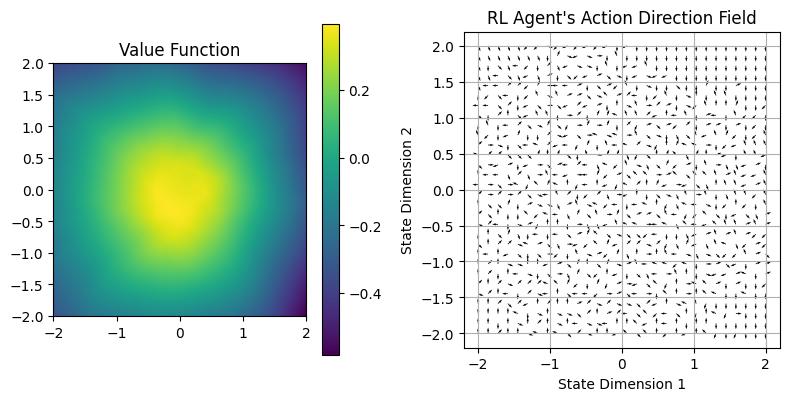

Episode 100: Total Loss: 1.8733, Actor Loss: 1.4781, Critic Loss: 0.3952, Return: 62.0, Steps: 100
Episode 101: Total Loss: -1.5455, Actor Loss: -2.3804, Critic Loss: 0.8350, Return: 10.0, Steps: 100
Episode 102: Total Loss: 2.3692, Actor Loss: 1.7968, Critic Loss: 0.5724, Return: 100.0, Steps: 100
Episode 103: Total Loss: -1.5875, Actor Loss: -2.4490, Critic Loss: 0.8616, Return: -40.0, Steps: 100
Episode 104: Total Loss: 1.9814, Actor Loss: 1.5604, Critic Loss: 0.4209, Return: -12.0, Steps: 100
Episode 105: Total Loss: 2.9904, Actor Loss: 2.2032, Critic Loss: 0.7872, Return: 10.0, Steps: 100
Episode 106: Total Loss: 2.6186, Actor Loss: 1.9401, Critic Loss: 0.6785, Return: 66.0, Steps: 100
Episode 107: Total Loss: 2.1197, Actor Loss: 1.6433, Critic Loss: 0.4764, Return: 62.0, Steps: 100
Episode 108: Total Loss: -1.4601, Actor Loss: -1.9941, Critic Loss: 0.5340, Return: -28.0, Steps: 100
Episode 109: Total Loss: -1.5543, Actor Loss: -2.5641, Critic Loss: 1.0098, Return: 22.0, Steps: 10

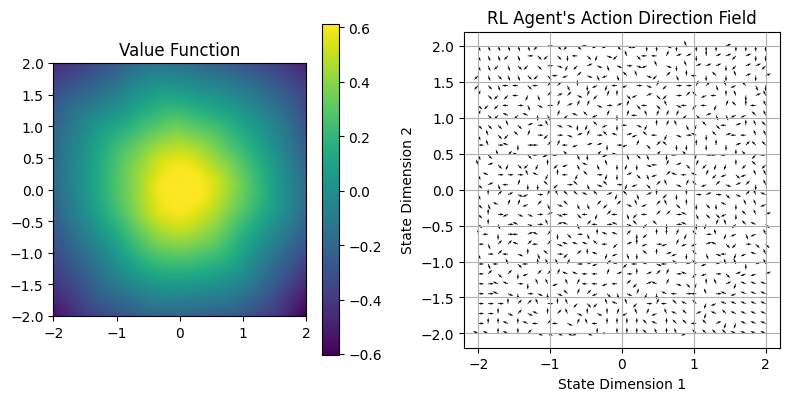

Episode 200: Total Loss: 1.8742, Actor Loss: 1.4880, Critic Loss: 0.3863, Return: -42.0, Steps: 100
Episode 201: Total Loss: -1.2908, Actor Loss: -1.6548, Critic Loss: 0.3640, Return: -64.0, Steps: 100
Episode 202: Total Loss: -1.5299, Actor Loss: -2.5058, Critic Loss: 0.9759, Return: 34.0, Steps: 100
Episode 203: Total Loss: 3.2008, Actor Loss: 2.3167, Critic Loss: 0.8841, Return: 14.0, Steps: 100
Episode 204: Total Loss: 2.2978, Actor Loss: 1.7475, Critic Loss: 0.5504, Return: 52.0, Steps: 100
Episode 205: Total Loss: 2.1298, Actor Loss: 1.6642, Critic Loss: 0.4656, Return: 32.0, Steps: 100
Episode 206: Total Loss: 2.8923, Actor Loss: 2.1470, Critic Loss: 0.7454, Return: 56.0, Steps: 100
Episode 207: Total Loss: 3.4876, Actor Loss: 2.5154, Critic Loss: 0.9722, Return: -32.0, Steps: 100
Episode 208: Total Loss: -1.5375, Actor Loss: -2.2039, Critic Loss: 0.6664, Return: -94.0, Steps: 100
Episode 209: Total Loss: 2.1407, Actor Loss: 1.6908, Critic Loss: 0.4499, Return: 100.0, Steps: 100

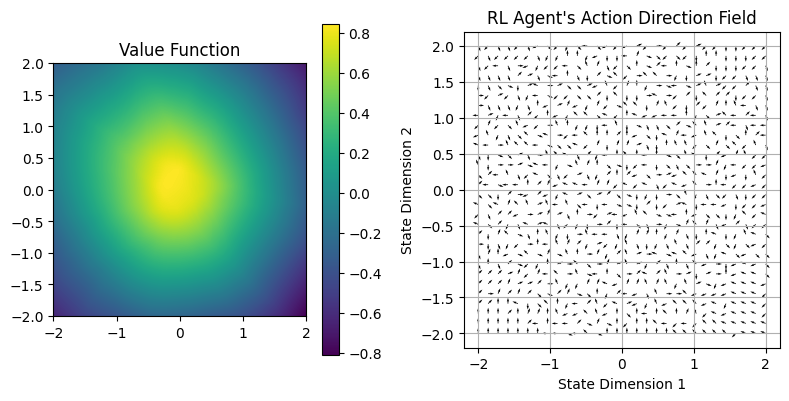

Episode 300: Total Loss: 3.8896, Actor Loss: 2.7872, Critic Loss: 1.1024, Return: -6.0, Steps: 100
Episode 301: Total Loss: -1.5719, Actor Loss: -2.4064, Critic Loss: 0.8345, Return: -80.0, Steps: 100
Episode 302: Total Loss: -1.5691, Actor Loss: -2.5822, Critic Loss: 1.0131, Return: 12.0, Steps: 100
Episode 303: Total Loss: 1.4841, Actor Loss: 1.2286, Critic Loss: 0.2555, Return: 100.0, Steps: 100
Episode 304: Total Loss: 2.4944, Actor Loss: 1.8592, Critic Loss: 0.6353, Return: 62.0, Steps: 100
Episode 305: Total Loss: -1.5200, Actor Loss: -2.7093, Critic Loss: 1.1893, Return: -72.0, Steps: 100
Episode 306: Total Loss: 1.0986, Actor Loss: 0.9422, Critic Loss: 0.1564, Return: -24.0, Steps: 100
Episode 307: Total Loss: 1.4548, Actor Loss: 1.2108, Critic Loss: 0.2439, Return: 82.0, Steps: 100
Episode 308: Total Loss: 1.9687, Actor Loss: 1.5471, Critic Loss: 0.4216, Return: 86.0, Steps: 100
Episode 309: Total Loss: 1.3393, Actor Loss: 1.1190, Critic Loss: 0.2203, Return: 28.0, Steps: 100


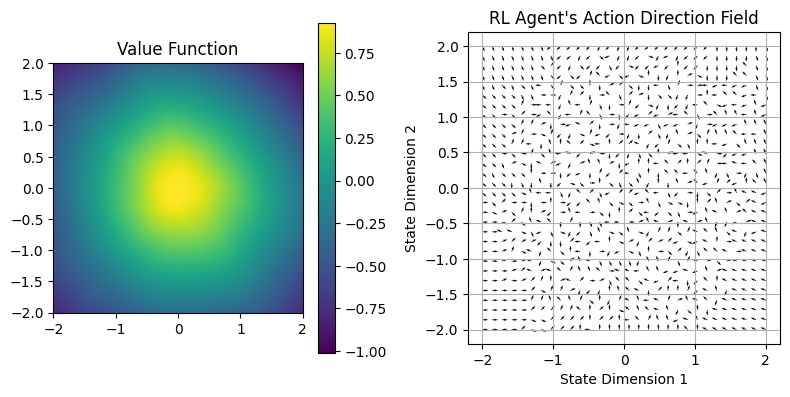

Episode 400: Total Loss: -1.1128, Actor Loss: -1.3529, Critic Loss: 0.2401, Return: -32.0, Steps: 100
Episode 401: Total Loss: 1.5233, Actor Loss: 1.2433, Critic Loss: 0.2800, Return: 44.0, Steps: 100
Episode 402: Total Loss: 0.2601, Actor Loss: 0.2494, Critic Loss: 0.0107, Return: 100.0, Steps: 100
Episode 403: Total Loss: 1.4600, Actor Loss: 1.1997, Critic Loss: 0.2603, Return: 22.0, Steps: 100
Episode 404: Total Loss: -1.4736, Actor Loss: -2.0147, Critic Loss: 0.5410, Return: -16.0, Steps: 100
Episode 405: Total Loss: 0.6269, Actor Loss: 0.5686, Critic Loss: 0.0583, Return: 44.0, Steps: 100
Episode 406: Total Loss: 1.4194, Actor Loss: 1.1709, Critic Loss: 0.2486, Return: 12.0, Steps: 100
Episode 407: Total Loss: 3.3713, Actor Loss: 2.4539, Critic Loss: 0.9175, Return: -18.0, Steps: 100
Episode 408: Total Loss: 3.2229, Actor Loss: 2.3272, Critic Loss: 0.8957, Return: 12.0, Steps: 100
Episode 409: Total Loss: 3.1909, Actor Loss: 2.3225, Critic Loss: 0.8684, Return: 28.0, Steps: 100
Ep

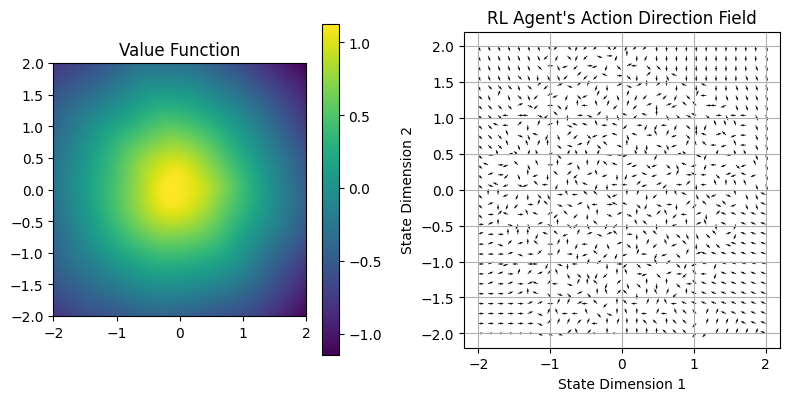

Episode 500: Total Loss: 2.5683, Actor Loss: 1.9299, Critic Loss: 0.6384, Return: -56.0, Steps: 100
Episode 501: Total Loss: 1.0077, Actor Loss: 0.8778, Critic Loss: 0.1298, Return: 48.0, Steps: 100
Episode 502: Total Loss: 1.1310, Actor Loss: 0.9635, Critic Loss: 0.1676, Return: 38.0, Steps: 100
Episode 503: Total Loss: -1.5773, Actor Loss: -2.3313, Critic Loss: 0.7540, Return: -14.0, Steps: 100
Episode 504: Total Loss: -1.5950, Actor Loss: -2.4738, Critic Loss: 0.8788, Return: 20.0, Steps: 100
Episode 505: Total Loss: 0.5390, Actor Loss: 0.4944, Critic Loss: 0.0446, Return: 68.0, Steps: 100
Episode 506: Total Loss: -1.5786, Actor Loss: -2.2965, Critic Loss: 0.7178, Return: 44.0, Steps: 100
Episode 507: Total Loss: 0.1963, Actor Loss: 0.1901, Critic Loss: 0.0062, Return: 100.0, Steps: 100
Episode 508: Total Loss: 0.9722, Actor Loss: 0.8523, Critic Loss: 0.1199, Return: 50.0, Steps: 100
Episode 509: Total Loss: 0.9412, Actor Loss: 0.8149, Critic Loss: 0.1263, Return: 66.0, Steps: 100
E

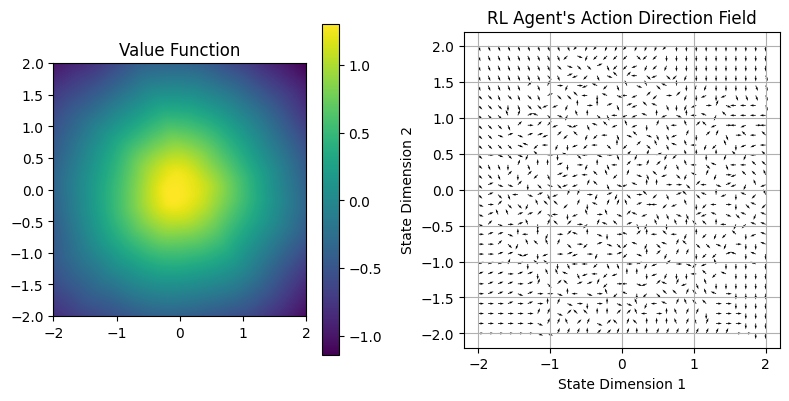

Episode 600: Total Loss: 2.7226, Actor Loss: 2.0534, Critic Loss: 0.6692, Return: 64.0, Steps: 100
Episode 601: Total Loss: 2.1032, Actor Loss: 1.6455, Critic Loss: 0.4576, Return: 26.0, Steps: 100
Episode 602: Total Loss: 2.9649, Actor Loss: 2.1888, Critic Loss: 0.7761, Return: 32.0, Steps: 100
Episode 603: Total Loss: 1.6733, Actor Loss: 1.3502, Critic Loss: 0.3231, Return: 98.0, Steps: 100
Episode 604: Total Loss: 0.9989, Actor Loss: 0.8648, Critic Loss: 0.1341, Return: -22.0, Steps: 100
Episode 605: Total Loss: 3.4385, Actor Loss: 2.4646, Critic Loss: 0.9739, Return: 36.0, Steps: 100
Episode 606: Total Loss: 1.8190, Actor Loss: 1.4451, Critic Loss: 0.3738, Return: 36.0, Steps: 100
Episode 607: Total Loss: 1.9829, Actor Loss: 1.5307, Critic Loss: 0.4522, Return: 58.0, Steps: 100
Episode 608: Total Loss: 0.4387, Actor Loss: 0.4044, Critic Loss: 0.0343, Return: 100.0, Steps: 100
Episode 609: Total Loss: 1.8447, Actor Loss: 1.4878, Critic Loss: 0.3569, Return: 76.0, Steps: 100
Episode 

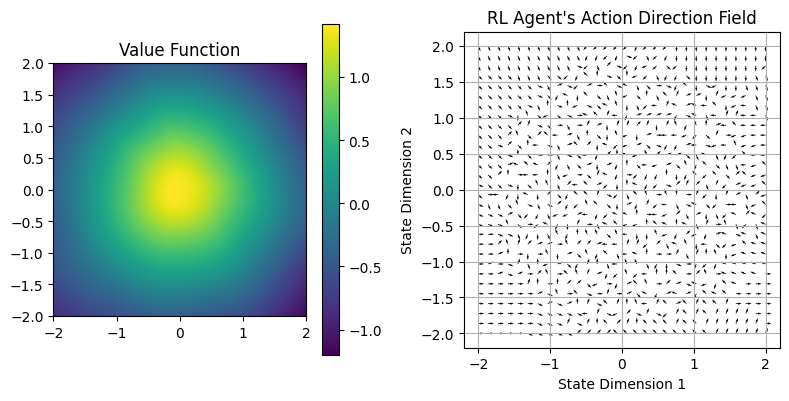

Episode 700: Total Loss: 0.3348, Actor Loss: 0.3167, Critic Loss: 0.0180, Return: 86.0, Steps: 100
Episode 701: Total Loss: 0.2369, Actor Loss: 0.2276, Critic Loss: 0.0093, Return: 100.0, Steps: 100
Episode 702: Total Loss: 1.3431, Actor Loss: 1.1330, Critic Loss: 0.2101, Return: 98.0, Steps: 100
Episode 703: Total Loss: 0.4744, Actor Loss: 0.4377, Critic Loss: 0.0367, Return: 8.0, Steps: 100
Episode 704: Total Loss: 3.2574, Actor Loss: 2.3600, Critic Loss: 0.8974, Return: -26.0, Steps: 100
Episode 705: Total Loss: 2.3050, Actor Loss: 1.7246, Critic Loss: 0.5805, Return: 60.0, Steps: 100
Episode 706: Total Loss: -0.4511, Actor Loss: -0.4902, Critic Loss: 0.0391, Return: 96.0, Steps: 100
Episode 707: Total Loss: 0.3332, Actor Loss: 0.3168, Critic Loss: 0.0164, Return: 22.0, Steps: 100
Episode 708: Total Loss: 0.0879, Actor Loss: 0.0865, Critic Loss: 0.0014, Return: 56.0, Steps: 100
Episode 709: Total Loss: 0.0833, Actor Loss: 0.0821, Critic Loss: 0.0012, Return: 94.0, Steps: 100
Episode

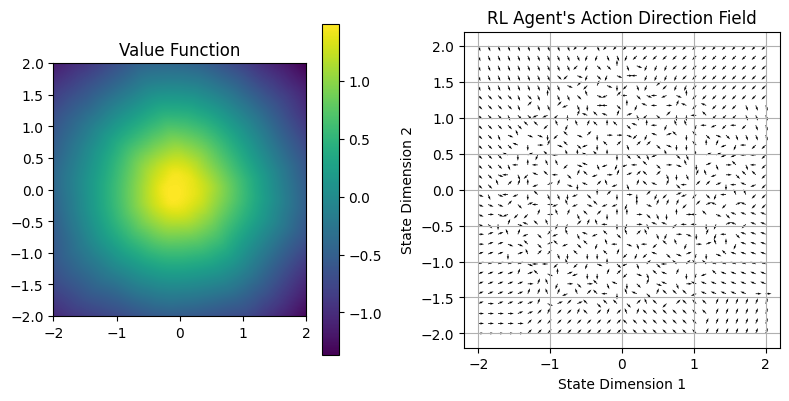

Episode 800: Total Loss: -1.5896, Actor Loss: -2.6157, Critic Loss: 1.0262, Return: 36.0, Steps: 100
Episode 801: Total Loss: 1.0415, Actor Loss: 0.9100, Critic Loss: 0.1315, Return: 100.0, Steps: 100
Episode 802: Total Loss: 1.6881, Actor Loss: 1.3514, Critic Loss: 0.3367, Return: 18.0, Steps: 100
Episode 803: Total Loss: 0.7741, Actor Loss: 0.6855, Critic Loss: 0.0886, Return: 64.0, Steps: 100
Episode 804: Total Loss: 0.1461, Actor Loss: 0.1427, Critic Loss: 0.0034, Return: 58.0, Steps: 100
Episode 805: Total Loss: -1.4830, Actor Loss: -2.4994, Critic Loss: 1.0164, Return: 32.0, Steps: 100
Episode 806: Total Loss: -1.5561, Actor Loss: -2.2988, Critic Loss: 0.7427, Return: 12.0, Steps: 100
Episode 807: Total Loss: -1.5058, Actor Loss: -2.0765, Critic Loss: 0.5707, Return: 28.0, Steps: 100
Episode 808: Total Loss: 1.3067, Actor Loss: 1.0966, Critic Loss: 0.2101, Return: 98.0, Steps: 100
Episode 809: Total Loss: -1.3987, Actor Loss: -2.6537, Critic Loss: 1.2550, Return: -6.0, Steps: 100

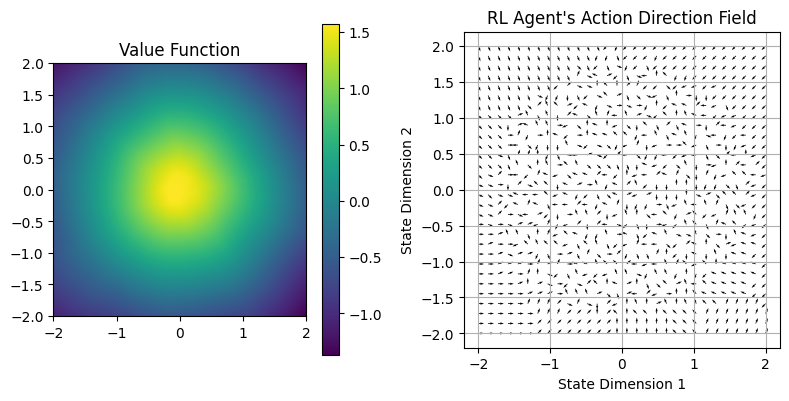

Episode 900: Total Loss: 0.2226, Actor Loss: 0.2138, Critic Loss: 0.0089, Return: 12.0, Steps: 100
Episode 901: Total Loss: 1.5526, Actor Loss: 1.2738, Critic Loss: 0.2788, Return: -22.0, Steps: 100
Episode 902: Total Loss: 2.3471, Actor Loss: 1.7834, Critic Loss: 0.5637, Return: 40.0, Steps: 100
Episode 903: Total Loss: 0.9666, Actor Loss: 0.8349, Critic Loss: 0.1317, Return: 60.0, Steps: 100
Episode 904: Total Loss: -1.5670, Actor Loss: -2.3045, Critic Loss: 0.7375, Return: 20.0, Steps: 100
Episode 905: Total Loss: -1.5319, Actor Loss: -2.6662, Critic Loss: 1.1343, Return: 86.0, Steps: 100
Episode 906: Total Loss: 1.9144, Actor Loss: 1.5099, Critic Loss: 0.4045, Return: 6.0, Steps: 100
Episode 907: Total Loss: 2.6009, Actor Loss: 1.9375, Critic Loss: 0.6634, Return: 66.0, Steps: 100
Episode 908: Total Loss: 2.1926, Actor Loss: 1.6854, Critic Loss: 0.5073, Return: 82.0, Steps: 100
Episode 909: Total Loss: -0.7509, Actor Loss: -0.8722, Critic Loss: 0.1213, Return: 100.0, Steps: 100
Epi

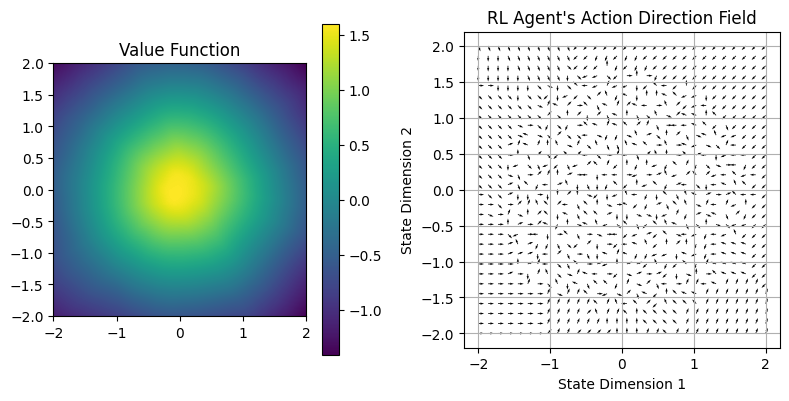

Episode 1000: Total Loss: 0.4267, Actor Loss: 0.4006, Critic Loss: 0.0260, Return: 50.0, Steps: 100
Episode 1001: Total Loss: 0.5340, Actor Loss: 0.4905, Critic Loss: 0.0434, Return: 100.0, Steps: 100
Episode 1002: Total Loss: 1.0589, Actor Loss: 0.9054, Critic Loss: 0.1535, Return: 62.0, Steps: 100
Episode 1003: Total Loss: -1.4608, Actor Loss: -2.6644, Critic Loss: 1.2036, Return: -10.0, Steps: 100
Episode 1004: Total Loss: -1.5881, Actor Loss: -2.6246, Critic Loss: 1.0365, Return: 96.0, Steps: 100
Episode 1005: Total Loss: 0.1321, Actor Loss: 0.1290, Critic Loss: 0.0031, Return: 100.0, Steps: 100
Episode 1006: Total Loss: 0.9420, Actor Loss: 0.8177, Critic Loss: 0.1243, Return: 82.0, Steps: 100
Episode 1007: Total Loss: 0.6950, Actor Loss: 0.6248, Critic Loss: 0.0702, Return: 68.0, Steps: 100
Episode 1008: Total Loss: 0.6477, Actor Loss: 0.5841, Critic Loss: 0.0635, Return: 0.0, Steps: 100
Episode 1009: Total Loss: 0.1567, Actor Loss: 0.1525, Critic Loss: 0.0041, Return: 54.0, Steps

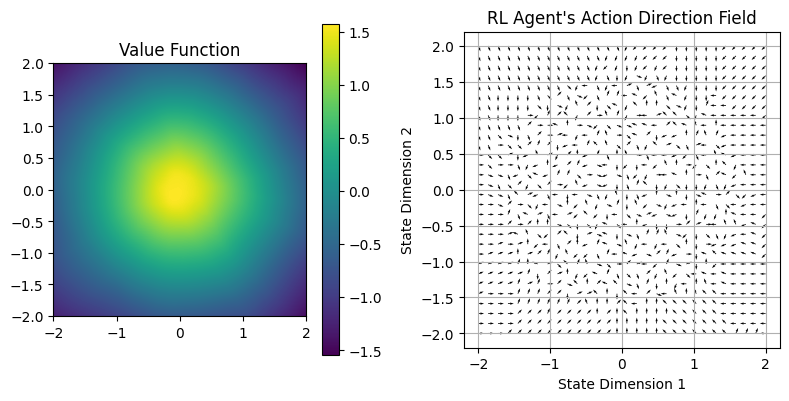

Episode 1100: Total Loss: -1.5788, Actor Loss: -2.7528, Critic Loss: 1.1740, Return: 80.0, Steps: 100
Episode 1101: Total Loss: 0.0059, Actor Loss: 0.0059, Critic Loss: 0.0000, Return: 58.0, Steps: 100
Episode 1102: Total Loss: 1.9089, Actor Loss: 1.5312, Critic Loss: 0.3777, Return: 92.0, Steps: 100
Episode 1103: Total Loss: 4.1965, Actor Loss: 2.9429, Critic Loss: 1.2536, Return: 34.0, Steps: 100
Episode 1104: Total Loss: 1.2780, Actor Loss: 1.0699, Critic Loss: 0.2080, Return: 18.0, Steps: 100
Episode 1105: Total Loss: -0.3713, Actor Loss: -0.3992, Critic Loss: 0.0280, Return: 46.0, Steps: 100
Episode 1106: Total Loss: -0.5712, Actor Loss: -0.6458, Critic Loss: 0.0746, Return: 98.0, Steps: 100
Episode 1107: Total Loss: 0.7253, Actor Loss: 0.6504, Critic Loss: 0.0749, Return: 38.0, Steps: 100
Episode 1108: Total Loss: -0.8710, Actor Loss: -1.0685, Critic Loss: 0.1976, Return: 96.0, Steps: 100
Episode 1109: Total Loss: 1.9878, Actor Loss: 1.5499, Critic Loss: 0.4379, Return: 64.0, Ste

KeyboardInterrupt: 

In [35]:
input_size = 2
num_actions = 16
model_shared = Shared_model(input_size, num_actions, hidden_size=64)
num_episodes = 10000
stats = actor_critic_bg(model_shared, num_episodes, lr_shared=1e-5, max_steps=100, gamma=0, n=num_actions)

In [12]:
model_shared = Shared_model(2, 16, 64)
model_shared.load_state_dict(torch.load('true_bg_disk.pth'))

C:\Users\g\AppData\Local\Temp\ipykernel_11148\4086296075.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_shared.load_state_dict(torch.load('true_bg_disk.pth'))


<All keys matched successfully>

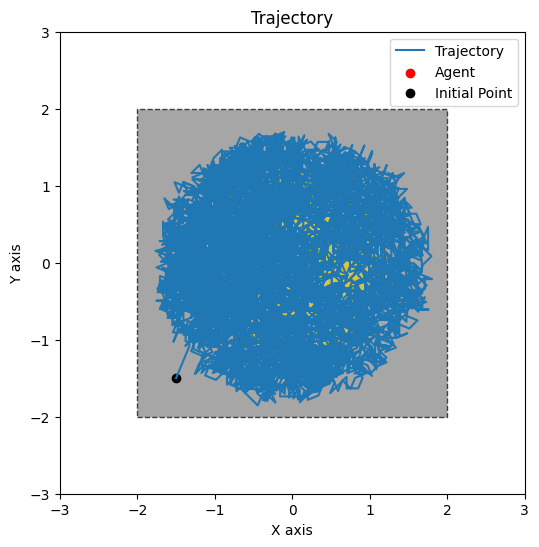

Total reward in human mode: 5886.0


In [42]:
env = MyEnv(16)
state = env.reset(init=True, point=np.array([-1.5, -1.5]))
done = False
total_reward = 0
max_steps = 10000
steps = 0
thresh = 0.0


while not done and steps < max_steps:
    if steps % 1000 ==0:
        clear_output(wait=True)
        env.render()
        plt.show()
        sleep(0.01)
    state_tensor = torch.FloatTensor(state)
    action_probs, val = model_shared(state_tensor, thresh)
    action_prob, action = torch.max(action_probs, dim=0)            
    state, reward, done, _ = env.step(action)
    total_reward += reward
    if steps >= max_steps:
        break
    steps+=1
print(f"Total reward in human mode: {total_reward}")

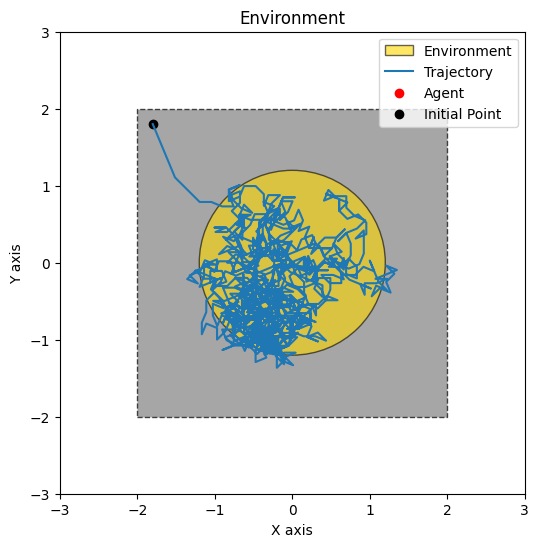

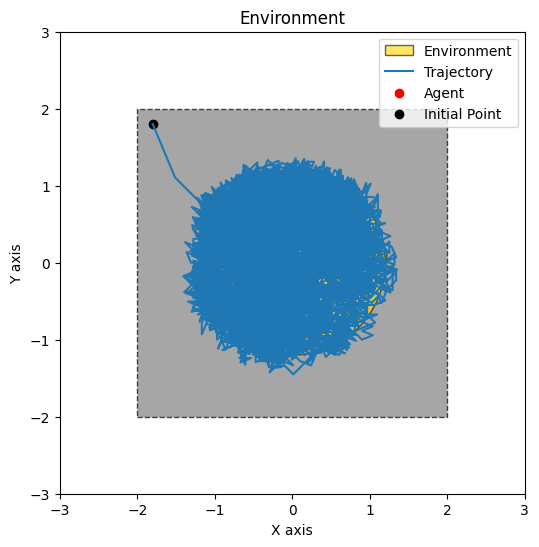

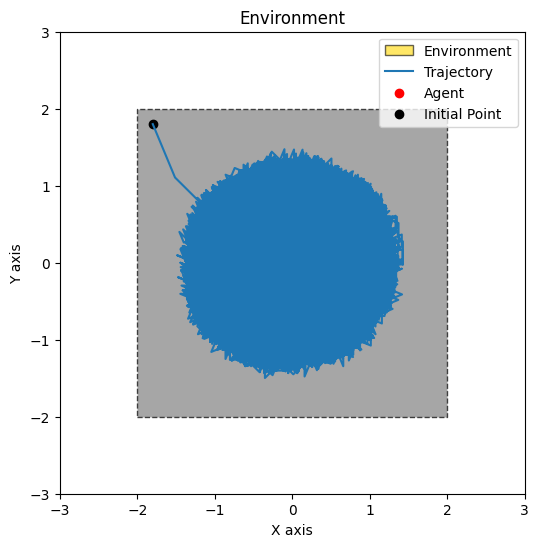

In [17]:
env = MyEnv(n=16)
state = env.reset(init=True, point=np.array([-1.8,1.8]))
done = False
total_reward = 0
max_steps = 100000
steps = 0
thresh = 0.5

while not done and steps < max_steps:
    state_tensor = torch.FloatTensor(state)
    action_probs, val = model_shared(state_tensor, thresh)
    action_prob, action = torch.max(action_probs, dim=0)            
    state, reward, done, _ = env.step(action)
    total_reward += reward
    if steps >= max_steps:
        break
    steps+=1
    if steps==1000 or steps==10000:
        env.render()
        plt.show()
env.render()
plt.show()

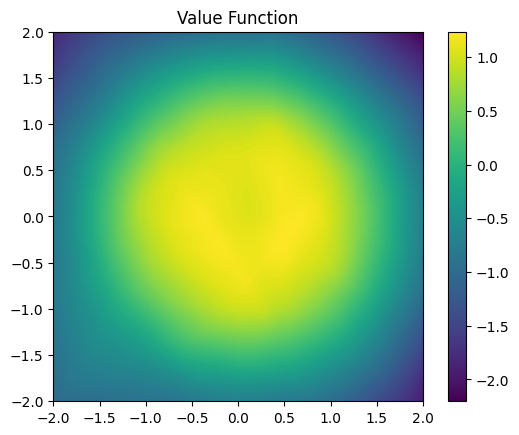

In [39]:
x = np.arange(-2, 2.01, 0.01)
y = np.arange(2, -2.01, -0.01)
xx, yy = np.meshgrid(x, y)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])
y_pred = np.squeeze(model_shared(torch.FloatTensor(grid_points))[1].detach().numpy()).reshape(401, 401)
plt.title('Value Function')
plt.imshow(y_pred, extent=[-2,2,-2,2])
plt.colorbar()

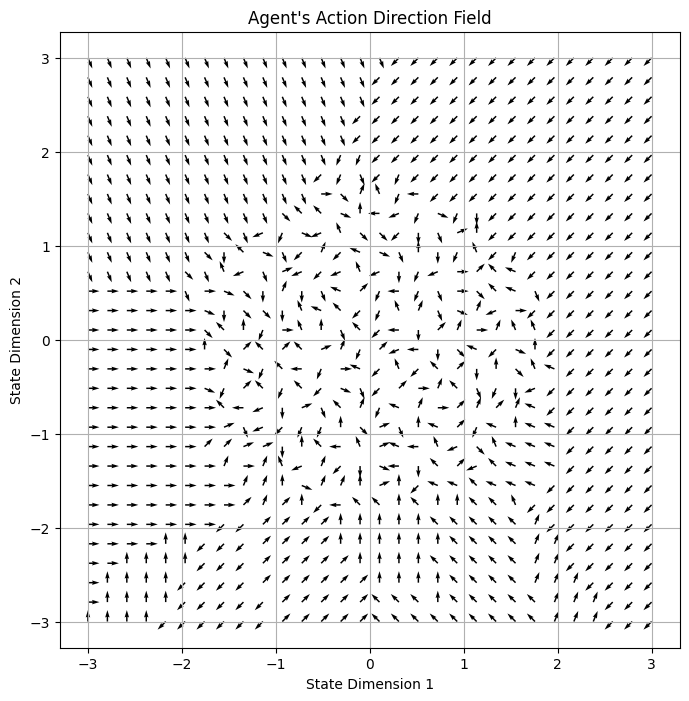

In [18]:
num_actions = 16
angles = np.linspace(0, 2 * np.pi, num_actions, endpoint=False)
action_vectors = np.stack((np.cos(angles), np.sin(angles)), axis=1)

# 2. Create a grid over the 2D space (e.g., from -1 to 1)
grid_size = 30
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)
X, Y = np.meshgrid(x, y)

# 3. Compute the agent's action at each point
U = np.zeros_like(X)  # x-component of vector
V = np.zeros_like(Y)  # y-component of vector

for i in range(grid_size):
    for j in range(grid_size):
        state = np.array([X[i, j], Y[i, j]])  # Modify if your state is higher-dimensional
        action_probs, val = model_shared(torch.FloatTensor(state),threshold=0)
        action_prob, action = torch.max(action_probs, dim=0)
        action_idx = action.item()
        direction = action_vectors[action_idx]
        U[i, j] = direction[0]
        V[i, j] = direction[1]

# 4. Plot using quiver
plt.figure(figsize=(8,8))
plt.quiver(X, Y, U, V, angles='xy')
plt.title("Agent's Action Direction Field")
plt.xlabel("State Dimension 1")
plt.ylabel("State Dimension 2")
plt.axis('equal')
plt.grid(True)
plt.show()
